# Recommender Systems Summative
# RS1

#### MovieLens dataset using collaborative filtering and content-based filtering

In [109]:
# !pip3 install surprise
import pandas as pd
import numpy as np
from surprise import Reader, Dataset
from surprise import SVD
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity

rposhala (2021). Recommender-System-on-MovieLens-dataset/Recommender_System_using_SVD.ipynb at main · rposhala/Recommender-System-on-MovieLens-dataset. [online] GitHub. Available at: https://github.com/rposhala/Recommender-System-on-MovieLens-dataset/blob/main/Recommender_System_using_SVD.ipynb![image.png](attachment:image.png)

In [110]:
# MOVE INFO
info = pd.read_csv('ml-100k/u.info', header=None)
print("Info: ", list(info[0]))

Info:  ['943 users', '1682 items', '100000 ratings']


In [111]:
# RATINGS DATA
# adding column name and reading file
rate_columns = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=rate_columns)

print(ratings.shape)
print("missing values: ", ratings.isnull().sum())
print(ratings.describe())
ratings.head()

(100000, 4)
missing values:  user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
            user_id       movie_id         rating     timestamp
count  100000.00000  100000.000000  100000.000000  1.000000e+05
mean      462.48475     425.530130       3.529860  8.835289e+08
std       266.61442     330.798356       1.125674  5.343856e+06
min         1.00000       1.000000       1.000000  8.747247e+08
25%       254.00000     175.000000       3.000000  8.794487e+08
50%       447.00000     322.000000       4.000000  8.828269e+08
75%       682.00000     631.000000       4.000000  8.882600e+08
max       943.00000    1682.000000       5.000000  8.932866e+08


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [112]:
# USER DATA
# adding column name and reading file
user_columns = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=user_columns)

print(users.shape)
users.head()

(943, 5)


,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [113]:
# ITEM DATA
# adding column name and reading file
item_columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'imdb_url', 'unknown', 'Action', 'Adventure', 'Animation', 
                'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                'Thriller', 'War', 'Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=item_columns)

# drop video release date as its na
items.drop('video_release_date', axis=1, inplace=True)
item_columns.remove('video_release_date')

print(items.shape)
items.head()

(1682, 23)


,movie_id,movie_title,release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [114]:
# checking for duplicates
item_duplicate = items.duplicated(subset=item_columns[1:])
print("duplicates: ", sum(item_duplicate))

## 18 duplicates

duplicates:  18


## Merging datasets

In [115]:
# merging using movie id
movie_merge = pd.merge(ratings, items, how='inner', on='movie_id')
print("missing values: ", movie_merge.isnull().sum())
movie_merge.head()

missing values:  user_id          0
movie_id         0
rating           0
timestamp        0
movie_title      0
release_date     9
imdb_url        13
unknown          0
Action           0
Adventure        0
Animation        0
Children's       0
Comedy           0
Crime            0
Documentary      0
Drama            0
Fantasy          0
Film-Noir        0
Horror           0
Musical          0
Mystery          0
Romance          0
Sci-Fi           0
Thriller         0
War              0
Western          0
dtype: int64


,user_id,movie_id,rating,timestamp,movie_title,release_date,imdb_url,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,881250949,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,875747190,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,883888671,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,879138235,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,876503793,Kolya (1996),24-Jan-1997,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# aggregating duplicated data using mean
movie_agg = movie_merge.groupby(['user_id', 'movie_title'], as_index=False).agg({'rating': 'mean'})
print(movie_agg.shape)
movie_agg.head()

(99693, 3)


,user_id,movie_title,rating
0,1,101 Dalmatians (1996),2.0
1,1,12 Angry Men (1957),5.0
2,1,"20,000 Leagues Under the Sea (1954)",3.0
3,1,2001: A Space Odyssey (1968),4.0
4,1,"Abyss, The (1989)",3.0


### Creating unique list for user and item

In [117]:
user_unique = movie_merge['user_id'].unique()
movie_unique = movie_merge['movie_title'].unique()
print("users: ", len(user_unique), "movies: ", len(movie_unique))

users:  943 movies:  1664


# Data Preparation


#### Creating a matrix between users and movies

In [118]:
ratings_matrix = movie_agg.pivot_table(index='user_id', columns='movie_title', values='rating').fillna(0)
ratings_matrix.head()

# sparse matrix

movie_title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,� k�ldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,2.0,5.0,0.0,0.0,3.0,4.0,0.0,0.0,...,0.0,0.0,0.0,5.0,3.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,2.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0


## Content-based filtering
### Memory-based approach
Jeong, Y. (2021). Making a Content-Based Movie Recommender With Python. [online] Geek Culture. Available at: https://medium.com/geekculture/creating-content-based-movie-recommender-with-python-7f7d1b739c63![image.png](attachment:image.png)

In [119]:
from sklearn.feature_extraction.text import TfidfTransformer

movie_content_based = movie_merge.copy()
movie_content_based_agg = movie_content_based.groupby('movie_title').agg('max')

movie_content_based_agg.drop(columns=['user_id','movie_id','rating','timestamp','release_date','imdb_url'], inplace=True)

tfidf_transformer = TfidfTransformer()

# fit and transform genre columns
tfidf_matrix = tfidf_transformer.fit_transform(movie_content_based_agg)
print(tfidf_matrix.shape)

(1664, 19)


In [120]:
# cosine similarity
from sklearn.metrics.pairwise import linear_kernel

# create matrix
similarity = linear_kernel(tfidf_matrix,tfidf_matrix)
print(similarity)

[[1.         0.84540816 0.         ... 0.         0.         0.34321811]
 [0.84540816 1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.85499204 0.         0.39739023]
 ...
 [0.         0.         0.85499204 ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.34321811 0.         0.39739023 ... 0.         0.         1.        ]]


## Collaborative filtering
### Model-based approach

divensambhwani (2019). MovieLens-100K_Recommender-System/MovieLens-100K-Recommeder System-SVD.ipynb at master · divensambhwani/MovieLens-100K_Recommender-System. [online] GitHub. Available at: https://github.com/divensambhwani/MovieLens-100K_Recommender-System/blob/master/MovieLens-100K-Recommeder%20System-SVD.ipynb![image.png](attachment:image.png)

In [121]:
reader = Reader()
data = Dataset.load_from_df(movie_merge[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

#### Training model

In [122]:
svd = SVD()

# train on training set
svd.fit(trainset)

# cross validating
cross_validate(svd, data, measures=['mae'], cv=3)

{'test_mae': array([0.74554372, 0.74655575, 0.74682338]),
 'fit_time': (2.660871982574463, 2.177736282348633, 1.0477087497711182),
 'test_time': (0.8670048713684082, 0.3624119758605957, 0.26328587532043457)}

## Evaluation Metrics

### MAE

In [123]:
param_grid = {'n_epochs': [5,10,15,20], 'lr_all': [0.008,0.01,0.012], 'reg_all': [0.08,0.1,0.12]}

grid_search = GridSearchCV(SVD, param_grid, measures=['mae'], cv=3)
grid_search.fit(data)

# setting best params
best = grid_search.best_params
epoch = best['mae']['n_epochs']
lr = best['mae']['lr_all']
reg = best['mae']['reg_all']

# print('Best estimator: ', grid_search.best_estimator['rmse'])
print('Best Parameters: ', grid_search.best_params['mae'])
print('Best MAE: ', grid_search.best_score['mae'])

Best Parameters:  {'n_epochs': 20, 'lr_all': 0.012, 'reg_all': 0.08}
Best MAE:  0.7301571146619527


In [124]:
# fitting data on new params
svd = SVD(n_epochs=epoch, lr_all=lr, reg_all=reg)

cross_validate(svd, data, measures=['mae'], cv=5)
predictions = svd.fit(trainset).test(testset)
accuracy.mae(predictions)

MAE:  0.7298


0.7298269222749753

### Novelty

In [125]:
## EVALUATION METRIC
# NOVELTY
def novelty(recommended_items, item_popularity):
    novelty_score = np.sum(np.fromiter((-np.log2(item_popularity.get(item, 1.0)/ len(user_unique)) for item in recommended_items), dtype=float))
    novelty_score /= len(recommended_items)
    return novelty_score

In [133]:
def user_novelty(movie_merge,predictions, N):

    novelty_scores = []
    user_ratings = defaultdict(list)
    for predict in predictions:
        user_ratings[predict.uid].append({"movie_id": predict.iid, "estimated_rating": predict.est})

    for user_id in user_unique:
        user_prediction = user_ratings[user_id]

        # get indices of top N items
        top_indices = sorted(user_prediction, key=lambda x: x["estimated_rating"], reverse=True)[:N]

        # getting movie titles by comparing with the indices in dictionary to movie merge dataframe
        top_movie_titles = movie_merge[movie_merge['movie_id'].isin(pred["movie_id"] for pred in top_indices)]['movie_title'].values
        top_movies_unique = list(set(top_movie_titles))

        # for novelty metric - calculate item pops to dictionary
        item_popularity = movie_merge[movie_merge['movie_title'].isin(top_movies_unique)]['movie_title'].value_counts().to_dict()
        # novelty score
        novelty_score = novelty(top_movies_unique, item_popularity)
        novelty_scores.append(novelty_score)
       
    avg_novelty = sum(novelty_scores)/ len(novelty_scores)
    print(f'Novelty Score: {avg_novelty}')

    
user_novelty(movie_merge,predictions, 5)

Novelty Score: 3.3458837612706027


### Hybrid Switching

In [129]:
#### THRESHOLD == 20
# all chosen users have rated at least 20 movies so any user with less than 20 rated movies
#    are considered "new users"

def user_interaction_history(user_id):
    user_history = movie_merge[movie_merge['user_id'] == user_id]
    
    # extract rated movies
    user_history_items = user_history['movie_id'].tolist()
    # incase there are duplicates
    user_history_items = list(set(user_history_items))
    
    return user_history_items


def switch_hybrid(user_id, movie_merge, threshold, N, fav_genre_chosen=None):
    # check user's interaction history
    user_history = user_interaction_history(user_id)
    
    if len(user_history) < threshold:
        # cold start - CBF
        content_based, _ = recommend_new_users(user_id, fav_genre_chosen, movie_merge, N)
        return content_based
    
    else:
        # CF
        cf_rec = recommend_based_on_user(user_id, 5)
        return cf_rec
    
# user_interaction_history(20)
# switch_hybrid(20, movie_merge, 20, 10, 5)

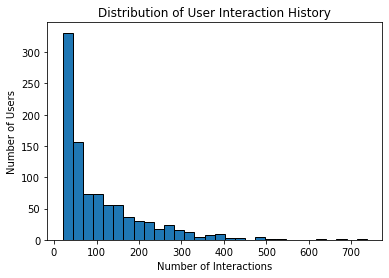

In [130]:
import matplotlib.pyplot as plt

# plotting interactions
all_user_interactions = []
for user_id in user_unique:
    interactions = user_interaction_history(user_id)
    all_user_interactions.append(interactions)
    
interaction_counts = [len(interactions) for interactions in all_user_interactions]

plt.hist(interaction_counts, bins=30, edgecolor='black')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.title('Distribution of User Interaction History')
plt.show()

25th Percentile: 33.0


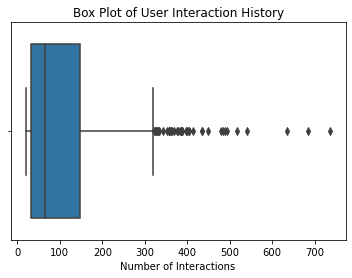

In [131]:
import seaborn as sns

lower_percentile = np.percentile(interaction_counts, 25)
print(f'25th Percentile: {lower_percentile}')

# box plot
sns.boxplot(x=interaction_counts)

plt.xlabel('Number of Interactions')
plt.title('Box Plot of User Interaction History')
plt.show()

### Making Recommendations

In [132]:
# predicting ratings for movies that has not been rated by users
trainset = data.build_full_trainset()
svd.fit(trainset)
testset = trainset.build_anti_testset()
predictions = svd.test(testset)

In [134]:
from collections import defaultdict
def recommend_based_on_user(user_id, N):

    user_ratings = defaultdict(list)
    for predict in predictions:
        user_ratings[predict.uid].append({"movie_id": predict.iid, "estimated_rating": predict.est})

    user_prediction = user_ratings[user_id]

    # get indices of top N items
    top_indices = sorted(user_prediction, key=lambda x: x["estimated_rating"], reverse=True)[:N]


    # getting movie titles by comparing with the indices in dictionary to movie merge dataframe
    top_movie_titles = movie_merge[movie_merge['movie_id'].isin(pred["movie_id"] for pred in top_indices)]['movie_title'].values
    top_movies_unique = list(set(top_movie_titles))
    print(f'Top {N} Recommendations for User {user_id}: ')
    for i in top_movies_unique:
        print(i)
    
recommend_based_on_user(943, 5)

Top 5 Recommendations for User 943: 
Much Ado About Nothing (1993)
Henry V (1989)
Pather Panchali (1955)
Good Will Hunting (1997)
Hard Eight (1996)


In [135]:
def recommend_based_on_genre(user_id, genre, N):
    
    user_ratings = defaultdict(list)
    for predict in predictions:
        user_ratings[predict.uid].append({"movie_id": predict.iid, "estimated_rating": predict.est})
    
    # get user's rated movies and ratings
    user_prediction = user_ratings[user_id]
    
    # get movies of chosen genre
    movie_genre = movie_merge[movie_merge[genre] == 1]
    
    # filtering only movies of selected genre
    movies_of_selected_genre = [movie for movie in user_prediction if movie['movie_id'] in movie_genre['movie_id'].values]
    
    # top movies for the genre
    top_genre = sorted(movies_of_selected_genre, key=lambda x: x["estimated_rating"], reverse=True)[:N]
    
    # get movie titles
    top_movie_titles = movie_merge[movie_merge['movie_id'].isin(pred["movie_id"] for pred in top_genre)]['movie_title'].values
    top_movies_unique = list(set(top_movie_titles))
        
    return top_movies_unique
        
# recommend_based_on_genre(1, "Animation", 5)

In [136]:
def recommend_popular_movies(N):
    user_ratings = defaultdict(list)
    for predict in predictions:
        user_ratings[predict.uid].append({"movie_id": predict.iid, "estimated_rating": predict.est})
    
    all_ratings = [rating for ratings_list in user_ratings.values() for rating in ratings_list]
    
    # get indices of top N items
    top_indices = sorted(all_ratings, key=lambda x: x["estimated_rating"], reverse=True)[:N]
    
    # getting movie titles by comparing with the indices in dictionary to movie merge dataframe
    top_movie_titles = movie_merge[movie_merge['movie_id'].isin(pred["movie_id"] for pred in top_indices)]['movie_title'].values
    top_movies_unique = list(set(top_movie_titles))
    print(f'Top Rated Movies: ')
    for i in top_movies_unique:
        print(i)
        
# recommend_popular_movies(10)

In [137]:
def recommend_new_users(user_id, fav_genre_chosen, movie_merge, N):
    # create user profile based on favourite genre
    user_profile = pd.DataFrame(columns=movie_content_based_agg.columns)
    user_profile.loc[0,fav_genre_chosen] = 1
    user_profile = user_profile.fillna(0)
    
    if user_id not in movie_merge['user_id'].values:
        # create profile to append to movie_merge df
        merge_profile = pd.DataFrame(columns=movie_merge.columns)
        merge_profile.loc[0,"user_id"] = user_id
        merge_profile.loc[0,fav_genre_chosen] = 1
        merge_profile = merge_profile.fillna(0)
        
        movie_merge = movie_merge.append(merge_profile)
    

    # calculating similarity between user profile and movies
    user_tfidf = tfidf_transformer.transform(user_profile)
    similarity_scores = linear_kernel(user_tfidf, tfidf_matrix)

    # movies with highest scores
    top_movie_scores = similarity_scores.argsort()[0][::-1]
    top_movie_scores = top_movie_scores[:N]

    top_movie_titles = movie_content_based_agg.index[top_movie_scores]

    return top_movie_titles, movie_merge

# recommend_new_users(944, "Adventure", movie_merge, 5)

In [138]:
## checking predictions err
def get_Iu(uid):
    """ 
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ 
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
    
movie_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
movie_pred['Iu'] = movie_pred.uid.apply(get_Iu)
movie_pred['Ui'] = movie_pred.iid.apply(get_Ui)
movie_pred['err'] = abs(movie_pred.est - movie_pred.rui)

movie_pred.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,196,302,3.52986,3.973555,{'was_impossible': False},39,297,0.443695
1,196,377,3.52986,2.788176,{'was_impossible': False},39,13,0.741684
2,196,51,3.52986,3.680722,{'was_impossible': False},39,81,0.150862
3,196,346,3.52986,3.364415,{'was_impossible': False},39,126,0.165445
4,196,474,3.52986,4.070119,{'was_impossible': False},39,194,0.540259


In [139]:
best_pred = movie_pred.sort_values(by='err')[:10]
worst_pred = movie_pred.sort_values(by='err')[-10:]

In [140]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
128230,594,1653,3.52986,3.529859,{'was_impossible': False},25,1,8.268211e-07
475968,564,1005,3.52986,3.529864,{'was_impossible': False},34,22,3.794005e-06
1329798,441,1119,3.52986,3.529856,{'was_impossible': False},20,59,3.812995e-06
28387,14,1245,3.52986,3.529864,{'was_impossible': False},98,19,4.046414e-06
1139684,689,882,3.52986,3.529856,{'was_impossible': False},36,34,4.321819e-06
1064875,300,444,3.52986,3.529865,{'was_impossible': False},20,46,5.002942e-06
1420959,857,1401,3.52986,3.529854,{'was_impossible': False},22,18,6.195908e-06
1341473,424,650,3.52986,3.529854,{'was_impossible': False},44,72,6.383273e-06
274105,15,718,3.52986,3.529852,{'was_impossible': False},104,16,7.836778e-06
536973,931,153,3.52986,3.529868,{'was_impossible': False},61,247,8.134357e-06


In [141]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
383514,445,743,3.52986,1.0,{'was_impossible': False},135,39,2.52986
68555,181,791,3.52986,1.0,{'was_impossible': False},435,10,2.52986
122383,206,758,3.52986,1.0,{'was_impossible': False},64,21,2.52986
69007,181,438,3.52986,1.0,{'was_impossible': False},435,6,2.52986
252618,405,1258,3.52986,1.0,{'was_impossible': False},737,23,2.52986
344450,490,457,3.52986,1.0,{'was_impossible': False},57,27,2.52986
252617,405,1213,3.52986,1.0,{'was_impossible': False},737,6,2.52986
68548,181,816,3.52986,1.0,{'was_impossible': False},435,21,2.52986
68566,181,314,3.52986,1.0,{'was_impossible': False},435,5,2.52986
68319,181,860,3.52986,1.0,{'was_impossible': False},435,16,2.52986


In [142]:
movie_merge.loc[movie_merge['movie_id'] == 571]['rating'].describe()

count    28.0
mean      2.5
std       1.0
min       1.0
25%       2.0
50%       3.0
75%       3.0
max       5.0
Name: rating, dtype: float64

### Recommender CLI display

In [143]:
def display_options():
    print("\t")
    print("Pick ONE of the following options:")
    print("1. Top movies recommended for you")
    print("2. Top movies for you based on genres")
    print("3. List popular movies")
    print("4. Exit")

In [144]:
def display_new_users_options():
    print("Options:")
    print("1. Top movies for you based on genres")
    print("2. List popular movies")
    print("3. Exit")

In [145]:
def display_genres():
    genres = []
    with open('ml-100k/u.genre', 'r') as file:
        for line in file:
            genre = line.strip().split('|')[0]
            if genre!= '' and genre!= "unknown":
                genres.append(genre)
    
    return genres
        
# display_genres()

In [147]:
def main():
    while True:
        print("Welcome to the Movie Recommender System!")
        print("This recommender system helps you discover movies based on your preferences.")
        print("You can choose to explore recommendations as an existing user or sign up as a new user.")
    
        print("\t")
        print("\nSelect the following options by entering its number.")
        
        print("1. Existing user")
        print("2. New user")
        print("3. Exit")
        user_choice = input(" ")
        
        
        if user_choice == "1":
            # existing user
            user_id = input("Enter your user ID: ")
            print(f"Welcome User {user_id}!")
            
            while True:
                display_options()
                
                print("\t")
                option_choice = input("Enter your choice (1-4): ")
                print("\t")
                if option_choice == "1":
                    # generate top movies for user
                    print("Generating recommendations...\t")
                    user_id = int(user_id)
                    recommend_based_on_user(user_id, 5)

                elif option_choice == "2":
                    # list all genres
                    print("List of Genres: ")
                    genres = display_genres()
                    for i, genre in enumerate(genres, start=1):
                        print(f"{i}. {genre}")
                    genre_choice = input("Enter the number of the genre you are interested in: ")
                    genre_chosen = genres[int(genre_choice)-1]

                    # then generate recommended movies for the genre
                    movies = recommend_based_on_genre(int(user_id), genre_chosen, 5)
                    print(f'Top 5 {genre_chosen} Movies Recommended for User {user_id}: ')
                    for i in movies:
                        print(i)

                elif option_choice == "3":
                    # generate overall popular movies
                    recommend_popular_movies(10)

                elif option_choice == "4":
                    print("Exiting to login page...\t")
                    break

                else:
                    print("Invalid choice. Please enter a number in the options.")

                
        elif user_choice == "2":
            # new user
            # log user in with new user id and display their user id
            user_id = len(user_unique) + 1
            
            print("\t")
            print(f'Your unique user ID is: {user_id} !')
            print("\t")
            print("Before we recommend you some movies, we want to understand you better!")
            print("Please pick your preferred genre(s). (You can separate them with comas(,)) \t")
            
            genres = display_genres()
            for i, genre in enumerate(genres, start=1):
                print(f"{i}. {genre}")
            
            # collect user's preferred genres
            favourite_genre = input("Enter your preferred genres: ")
            selected_genre = [int(genre_number.strip()) for genre_number in favourite_genre.split(',')]
            fav_genre_chosen = [genres[number-1] for number in selected_genre]
            
            # pick between hybrid
            # set threshold to min rating (20) and recommend 10 movies
            movies = switch_hybrid(user_id, movie_merge, 20, 10, fav_genre_chosen)
            
            print("\t Based on your selected genres, we recommend the following movies for you: ")
            for i in movies:
                print(i)
            
            print("\t")
            # then ask user if they wish to continue with recommendations
            further_reco = input("Do you wish to explore further with your personalised recommendations? (Y/N) ")
                
            if (further_reco == "Y"):
                
                while further_reco == "Y":

                    display_new_users_options()
                    print("\t")
                    option_choice = input("Enter your choice (1-3): ")
                    if option_choice == "1":
                        # generate top movies for user
                        genres = display_genres()
                        for i, genre in enumerate(genres, start=1):
                            print(f"{i}. {genre}")

                        # collect user's preferred genres
                        favourite_genre = input("Enter your preferred genres: ")
                        selected_genre = [int(genre_number.strip()) for genre_number in favourite_genre.split(',')]
                        fav_genre_chosen = [genres[number-1] for number in selected_genre]

                        # pick between hybrid
                        # set threshold to min rating (20) and recommend 10 movies
                        movies = switch_hybrid(user_id, movie_merge, 20, 10, fav_genre_chosen)
                        
                        print("\t")
                        print("Based on your selected genres, we recommend the following movies for you: ")
                        for i in movies:
                            print(i)

                    elif option_choice == "2":
                        # generate overall popular movies
                        recommend_popular_movies(10)

                    elif option_choice == "3":
                        print("Exiting. Goodbye!")
                        break

                    else:
                        print("Invalid choice. Please enter a number in the options.")

                    
                    print("\t")
                    further_reco = input("Do you wish to explore different recommendations? (Y/N) ")

            elif further_reco == "N":
                print("Exiting. Goodbye!")
                break
            
            else: # when user gives wrong input
                print("Invalid input. Please enter Y/N.")
                
        elif user_choice == "3":
            print("Exiting. Goodbye!")
            break
                
    

if __name__ == "__main__":
    main()

Welcome to the Movie Recommender System!
This recommender system helps you discover movies based on your preferences.
You can choose to explore recommendations as an existing user or sign up as a new user.
	

Select the following options by entering its number.
1. Existing user
2. New user
3. Exit
 1
Enter your user ID: 20
Welcome User 20!
	
Pick ONE of the following options:
1. Top movies recommended for you
2. Top movies for you based on genres
3. List popular movies
4. Exit
	
Enter your choice (1-4): 1
	
Generating recommendations...	
Top 5 Recommendations for User 20: 
Wrong Trousers, The (1993)
Grand Day Out, A (1992)
As Good As It Gets (1997)
Pather Panchali (1955)
Titanic (1997)
	
Pick ONE of the following options:
1. Top movies recommended for you
2. Top movies for you based on genres
3. List popular movies
4. Exit
	
Enter your choice (1-4): 2
	
List of Genres: 
1. Action
2. Adventure
3. Animation
4. Children's
5. Comedy
6. Crime
7. Documentary
8. Drama
9. Fantasy
10. Film-Noir